In [24]:
import networkx as nx
%matplotlib inline

In [25]:
!pip install nxviz

In [26]:
# import usefull packages

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Import Line2D for custom legend handles

# import usefull packages
import numpy as np
import nxviz as nv
import seaborn as sns
import plotly.graph_objects as go
from nxviz import annotate, highlights


# Leitura do csv e separação dos dados

In [27]:
df = pd.read_csv('/content/orquestras.csv', delimiter=';')

display(df.head())

,Obra,Compositor,Instrumentos
0,Sinfonia nº 5,Ludwig van Beethoven,"violino,viola,violoncelo,contrabaixo,piccolo,f..."
1,Eine kleine Nachtmusik,Wolfgang Amadeus Mozart,"violino,viola,violoncelo,contrabaixo"
2,As Quatro Estações,Antonio Vivaldi,"violino,viola,violoncelo,cravo,órgão"
3,Abertura 1812,Piotr Ilyich Tchaikovsky,"violino,viola,violoncelo,contrabaixo,piccolo,f..."
4,Cavalgada das Valquírias,Richard Wagner,"violino,viola,violoncelo,contrabaixo,piccolo,f..."


In [28]:
obras = {obra for obra in df['Obra']}

instrumentos_set = set()
for instrumentos in df['Instrumentos']:
  for instrumento in instrumentos.split(','):
    instrumentos_set.add(instrumento)

In [29]:
instrumentos_cordas = [
    'alaúde',
    'baixo',
    'contrabaixo',
    'guitarra',
    'harpa',
    'viola',
    'violino',
    'violoncelo'
]

instrumentos_sopro = [
    'clarinete',
    'corne inglês',
    'contrafagote',
    'fagote',
    'flauta',
    'oboé',
    'piccolo',
    'saxofone',
    'corneta',
    'oficleide',
    'trombone',
    'trompa',
    'trompa francesa',
    'trompete',
    'tuba'
]

instrumentos_tecla = [
    'celesta',
    'cravo',
    'órgão',
    'piano',
    'sintetizadores'
]

instrumentos_percussao = [
    'carrilhão',
    'crótalo',
    'glockenspiel',
    'tímpano',
    'xilofone',
    'bloco de madeira',
    'bumbo',
    'bumbo de concerto',
    'caixa',
    'canhão',
    'castanhola',
    'chocalho',
    'clave',
    'gongo',
    'guiro',
    'pandeireta',
    'prato',
    'pratos',
    'tabor',
    'tam-tam',
    'triângulo',
    'bateria'
]

# Gráfo geral


In [30]:
G = nx.Graph()

obras = {obra for obra in df['Obra']}
G.add_nodes_from(obras)

for instrumentos in df['Instrumentos']:
  for instrumento in instrumentos.split(','):
    if instrumento in instrumentos_cordas:
      G.add_node(instrumento, group= 'corda')
    elif instrumento in instrumentos_sopro:
      G.add_node(instrumento, group= 'sopro')
    elif instrumento in instrumentos_tecla:
      G.add_node(instrumento, group= 'tecla')
    else:
      G.add_node(instrumento, group= 'percussao')

for obra, instrumentos in zip(df['Obra'], df['Instrumentos']):
  for instrumento in instrumentos.split(','):
    G.add_edge(obra, instrumento)


for instrumentos in df['Instrumentos']:
  for i in range(len(instrumentos.split(','))):
    for j in range(i+1, len(instrumentos.split(','))):
      instrumento1 = instrumentos.split(',')[i]
      instrumento2 = instrumentos.split(',')[j]
      G.add_edge(instrumento1, instrumento2)

colors = []
for node in G.nodes():
  if 'group' in G.nodes[node]:
    if G.nodes[node]['group'] == 'corda':
      colors.append('blue')
    elif G.nodes[node]['group'] == 'sopro':
      colors.append('green')
    elif G.nodes[node]['group'] == 'tecla':
      colors.append('red')
    elif G.nodes[node]['group'] == 'percussao':
      colors.append('yellow')
  else:
    colors.append('black')

In [31]:
fig = go.Figure()

fig = go.Figure()
pos = nx.random_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'))

node_list = list(G.nodes())
for j, node in enumerate(node_list):
    position = pos[node]
    fig.add_trace(go.Scatter(
        x=[position[0]],
        y=[position[1]],
        mode='markers',
        marker=dict(color=colors[j], size=15),
        text=str(node),
        name=str(node)))

fig.update_layout(
    title="Gráfo dos instrumentos",
    showlegend=True,
    legend_title_text="Nós",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()

# Gráfo com pesos

In [32]:
G = nx.Graph()

G.add_nodes_from(instrumentos_set)

instrumentos_set = set()
for instrumentos in df['Instrumentos']:
  for instrumento in instrumentos.split(','):
    instrumentos_set.add(instrumento)

for instrumentos in df['Instrumentos']:
  for i in range(len(instrumentos.split(','))):
    for j in range(i+1, len(instrumentos.split(','))):
      instrumento1 = instrumentos.split(',')[i]
      instrumento2 = instrumentos.split(',')[j]
      if not(G.has_edge(instrumento1, instrumento2) or G.has_edge(instrumento2, instrumento1)):
        G.add_edge(instrumento1, instrumento2, weight = 1)
      else:
        G.edges[instrumento1, instrumento2]['weight'] += 1


pos = nx.spring_layout(G, k=5, iterations=200, seed=42)

edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

edge_traces = []

for i, edge in enumerate(G.edges()):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    trace = go.Scatter(
        x=[x0, x1, None], y=[y0, y1, None],
        line=dict(width=edge_weights[i] * 0.3, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(trace)


# Criar traço para os nós
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers', hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

fig = go.Figure(data=edge_traces + [node_trace],
             layout=go.Layout(
                title='<br>Grafo Interativo de Instrumentos com Pesos das Arestas',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# Análise do gráfo de instrumentos

In [33]:
G = nx.Graph()

for instrumentos in df['Instrumentos']:
  for instrumento in instrumentos.split(','):
    if instrumento in instrumentos_cordas:
      G.add_node(instrumento, group= 'corda')
    elif instrumento in instrumentos_sopro:
      G.add_node(instrumento, group= 'sopro')
    elif instrumento in instrumentos_tecla:
      G.add_node(instrumento, group= 'tecla')
    else:
      G.add_node(instrumento, group= 'percussao')


for instrumentos in df['Instrumentos']:
  for i in range(len(instrumentos.split(','))):
    for j in range(i+1, len(instrumentos.split(','))):
      instrumento1 = instrumentos.split(',')[i]
      instrumento2 = instrumentos.split(',')[j]
      G.add_edge(instrumento1, instrumento2)

colors = []
for node in G.nodes():
  if G.nodes[node]['group'] == 'corda':
    colors.append('blue')
  elif G.nodes[node]['group'] == 'sopro':
    colors.append('green')
  elif G.nodes[node]['group'] == 'tecla':
    colors.append('red')
  else:
    colors.append('yellow')

# G.nodes(data=True)
print(instrumentos_set)

{'castanhola', 'tabor', 'piccolo', 'flauta', 'glockenspiel', 'tímpano', 'caixa', 'bumbo de concerto', 'violoncelo', 'saxofone', 'corne inglês', 'prato', 'trompa', 'bumbo', 'triângulo', 'clarinete', 'oboé', 'trompa francesa', 'tuba', 'fagote', 'bateria', 'oficleide', 'contrabaixo', 'órgão', 'violino', 'alaúde', 'baixo', 'clave', 'canhão', 'harpa', 'piano', 'carrilhão', 'crótalo', 'celesta', 'tam-tam', 'guiro', 'sintetizadores', 'cravo', 'contrafagote', 'chocalho', 'pratos', 'guitarra', 'bloco de madeira', 'viola', 'gongo', 'trombone', 'xilofone', 'pandeireta', 'trompete', 'corneta'}


In [34]:
fig = go.Figure()

pos = nx.spring_layout(G)
node_list = list(G.nodes())
for j, node in enumerate(node_list):
    position = pos[node]
    fig.add_trace(go.Scatter(x=[position[0]],
                                 y=[position[1]],
                                 mode='markers',
                                 marker=dict(color=colors[j], size=15),
                                 text=str(node),
                                 name=str(node)))

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig.add_trace(go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='gray'),
                             hoverinfo='none', mode='lines'))

fig.update_layout(title="Gráfo dos instrumentos",
                  showlegend=True,
                  legend_title_text="Nós",
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

fig.show()


In [35]:
G.nodes(data=True)

NodeDataView({'violino': {'group': 'corda'}, 'viola': {'group': 'corda'}, 'violoncelo': {'group': 'corda'}, 'contrabaixo': {'group': 'corda'}, 'piccolo': {'group': 'sopro'}, 'flauta': {'group': 'sopro'}, 'oboé': {'group': 'sopro'}, 'clarinete': {'group': 'sopro'}, 'fagote': {'group': 'sopro'}, 'contrafagote': {'group': 'sopro'}, 'trompa': {'group': 'sopro'}, 'trompete': {'group': 'sopro'}, 'trombone': {'group': 'sopro'}, 'tímpano': {'group': 'percussao'}, 'cravo': {'group': 'tecla'}, 'órgão': {'group': 'tecla'}, 'corne inglês': {'group': 'sopro'}, 'corneta': {'group': 'sopro'}, 'tuba': {'group': 'sopro'}, 'bumbo': {'group': 'percussao'}, 'caixa': {'group': 'percussao'}, 'pratos': {'group': 'percussao'}, 'pandeireta': {'group': 'percussao'}, 'triângulo': {'group': 'percussao'}, 'carrilhão': {'group': 'percussao'}, 'canhão': {'group': 'percussao'}, 'glockenspiel': {'group': 'percussao'}, 'harpa': {'group': 'corda'}, 'alaúde': {'group': 'corda'}, 'castanhola': {'group': 'percussao'}, 'cho

In [36]:
G.degree()

DegreeView({'violino': 49, 'viola': 49, 'violoncelo': 49, 'contrabaixo': 48, 'piccolo': 38, 'flauta': 42, 'oboé': 43, 'clarinete': 42, 'fagote': 43, 'contrafagote': 40, 'trompa': 42, 'trompete': 48, 'trombone': 47, 'tímpano': 43, 'cravo': 10, 'órgão': 30, 'corne inglês': 37, 'corneta': 28, 'tuba': 43, 'bumbo': 42, 'caixa': 40, 'pratos': 46, 'pandeireta': 36, 'triângulo': 43, 'carrilhão': 33, 'canhão': 22, 'glockenspiel': 35, 'harpa': 35, 'alaúde': 4, 'castanhola': 27, 'chocalho': 27, 'tam-tam': 36, 'xilofone': 34, 'piano': 38, 'celesta': 32, 'baixo': 27, 'gongo': 19, 'crótalo': 22, 'guiro': 22, 'saxofone': 22, 'trompa francesa': 15, 'bateria': 15, 'bumbo de concerto': 15, 'sintetizadores': 15, 'guitarra': 15, 'oficleide': 18, 'prato': 22, 'clave': 22, 'tabor': 22, 'bloco de madeira': 22})

In [37]:
degrees = [deg for node, deg in G.degree()]

print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
print(f"Average degree alternative: {nx.density(G)*(G.number_of_nodes()-1):.2f}")


Min degree: 4
Max degree: 49
Average degree: 31.88
Average degree alternative: 31.88


In [38]:
degrees = [(node,deg) for node, deg in G.degree()]

degrees.sort(key=lambda item: item[1])
print(degrees[:3])
print(degrees[:len(degrees)-4:-1])

[('alaúde', 4), ('cravo', 10), ('trompa francesa', 15)]
[('violoncelo', 49), ('viola', 49), ('violino', 49)]


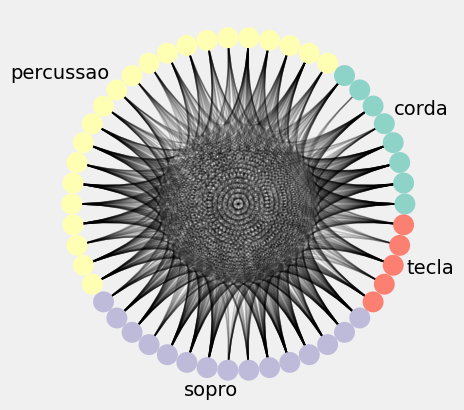

In [39]:
ax = nv.circos(G,
               group_by="group",
               node_color_by="group",
               #edge_alpha_by="edge_value"
)
annotate.circos_group(G, group_by="group")

# Save figure
plt.savefig("assortativity.png",
            format="png",
            dpi=400,
            bbox_inches="tight",
            transparent=True)

# Display graph
plt.show()

In [40]:
# Calculate number of nodes (vertices)
num_nodes = G.number_of_nodes()

# Calculate number of edges (links)
num_edges = G.number_of_edges()

# Calculate network density
density = nx.density(G)

# Print basic network statistics
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Network density: {density:.6f}")

Number of nodes: 50
Number of edges: 797
Network density: 0.650612


In [41]:
# Rede Disassortativa
# Não há uma preferência clara. As conexões parecem ser aleatórias em relação ao grau dos nós.
nx.attribute_assortativity_coefficient(G,"group")

-0.01930275534337618

In [42]:
# average degree of neighbors
degree, avg_neigh_degree = zip(*nx.average_degree_connectivity(G).items())

# convert to list
degree = list(degree)
avg_neigh_degree = list(avg_neigh_degree)

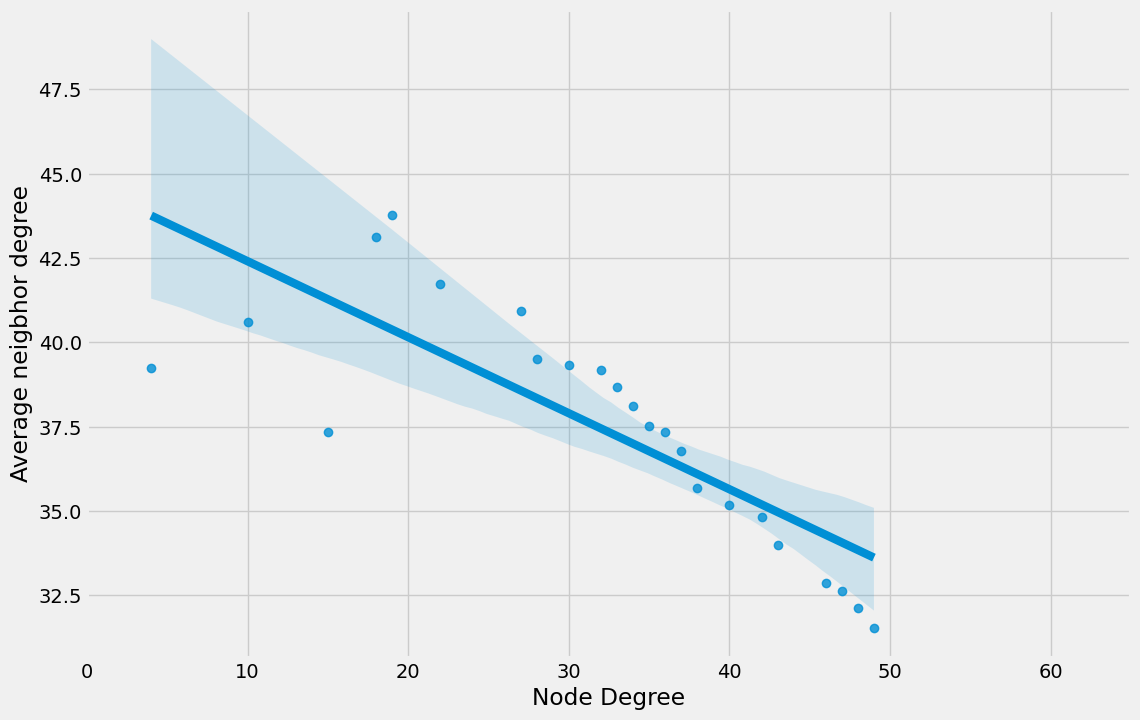

In [43]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.regplot(x=degree,y=avg_neigh_degree,ax=ax)

ax.set_xlabel("Node Degree")
ax.set_ylabel("Average neigbhor degree")
ax.set_xlim(0,65)

plt.savefig("degree_assortativity.png",
            format="png",
            dpi=400,
            bbox_inches="tight",
            transparent=True)

plt.show()

In [44]:
# à medida que o grau de um nó aumenta (eixo X), o grau médio de seus vizinhos tende a diminuir (eixo Y)
nx.degree_assortativity_coefficient(G)

-0.29532919050811485